# ResNet-50 Models

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers as tkl
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [3]:
X_train = X_train / 255
X_test = X_test / 255

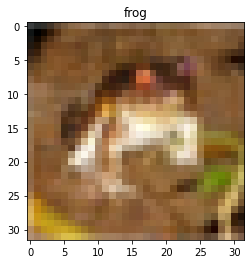

In [4]:
plt.imshow(X_train[0], cmap = "Greys_r")
plt.title(classes[y_train[0]])
plt.show()

In [5]:
def residual_block(X, concat, filters, kernel_size):
    conv3x3_v1 = tkl.Conv2D(filters, kernel_size = kernel_size, strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(X)
    conv3x3_v2 = tkl.Conv2D(filters, kernel_size = kernel_size, strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(conv3x3_v1)
    output = tkl.Concatenate(axis = 3)([conv3x3_v2, concat])
    return output, conv3x3_v2

### 1. ResNet Model v1 - 2

In [6]:
def resnet_v1():
    input_layer = keras.Input(shape = (32, 32, 3), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R3)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv1")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [7]:
resnet_v1 = resnet_v1()

Metal device set to: Apple M1 Pro


2022-10-25 18:22:43.291915: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 18:22:43.292020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
history = resnet_v1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20


2022-10-25 18:22:43.778608: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 18:22:44.034606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.6665 - accuracy: 0.3808

2022-10-25 18:23:17.604262: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 38s 24ms/step - loss: 1.6665 - accuracy: 0.3808 - val_loss: 1.3887 - val_accuracy: 0.4912
Epoch 2/20
1563/1563 [==============================] - 37s 24ms/step - loss: 1.2805 - accuracy: 0.5371 - val_loss: 1.1748 - val_accuracy: 0.5770
Epoch 3/20
1563/1563 [==============================] - 37s 24ms/step - loss: 1.1117 - accuracy: 0.6029 - val_loss: 1.1096 - val_accuracy: 0.6028
Epoch 4/20
1563/1563 [==============================] - 37s 24ms/step - loss: 1.0046 - accuracy: 0.6420 - val_loss: 0.9953 - val_accuracy: 0.6420
Epoch 5/20
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9314 - accuracy: 0.6713 - val_loss: 0.9368 - val_accuracy: 0.6685
Epoch 6/20
1563/1563 [==============================] - 37s 24ms/step - loss: 0.8758 - accuracy: 0.6925 - val_loss: 0.8694 - val_accuracy: 0.6909
Epoch 7/20
1563/1563 [==============================] - 37s 24ms/step - loss: 0.8238 - accuracy: 0.7115 - val_loss: 0.8369 - val_accura

In [9]:
predictions = resnet_v1.predict(X_test)

 16/313 [>.............................] - ETA: 2s

2022-10-25 18:35:03.015783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 7ms/step


In [10]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

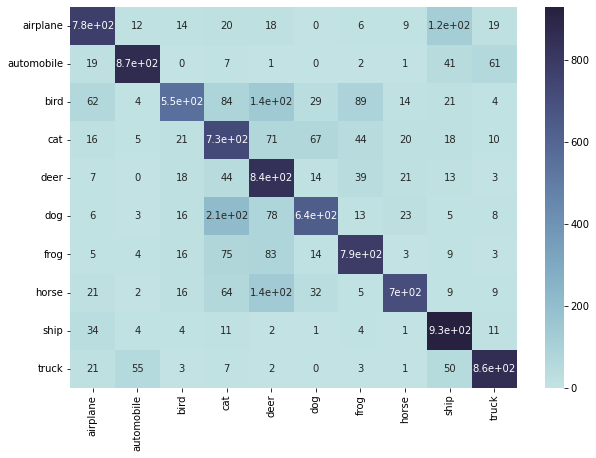

In [11]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

### 2. ResNet Model v2 - 4

In [12]:
def resnet_v2():
    input_layer = keras.Input(shape = (32, 32, 3), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P2 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R3)
    
    R4, A4 = residual_block(P2, P2, 128, (3, 3))
    R5, A5 = residual_block(R4, A4, 128, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R5)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv2")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [13]:
resnet_v2 = resnet_v2()

In [14]:
history = resnet_v2.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20


2022-10-25 18:38:42.740890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.4823 - accuracy: 0.4515

2022-10-25 18:39:36.358947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 58s 37ms/step - loss: 1.4823 - accuracy: 0.4515 - val_loss: 1.1049 - val_accuracy: 0.5914
Epoch 2/20
1563/1563 [==============================] - 58s 37ms/step - loss: 0.9771 - accuracy: 0.6523 - val_loss: 0.8957 - val_accuracy: 0.6800
Epoch 3/20
1563/1563 [==============================] - 57s 37ms/step - loss: 0.7669 - accuracy: 0.7307 - val_loss: 0.7273 - val_accuracy: 0.7513
Epoch 4/20
1563/1563 [==============================] - 58s 37ms/step - loss: 0.6358 - accuracy: 0.7783 - val_loss: 0.6868 - val_accuracy: 0.7649
Epoch 5/20
1563/1563 [==============================] - 58s 37ms/step - loss: 0.5427 - accuracy: 0.8115 - val_loss: 0.5792 - val_accuracy: 0.8029
Epoch 6/20
1563/1563 [==============================] - 58s 37ms/step - loss: 0.4683 - accuracy: 0.8385 - val_loss: 0.6509 - val_accuracy: 0.7812
Epoch 7/20
1563/1563 [==============================] - 57s 36ms/step - loss: 0.4101 - accuracy: 0.8560 - val_loss: 0.5995 - val_accura

In [15]:
predictions = resnet_v2.predict(X_test)

  6/313 [..............................] - ETA: 3s 

2022-10-25 18:58:10.929340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 6s 18ms/step


In [16]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

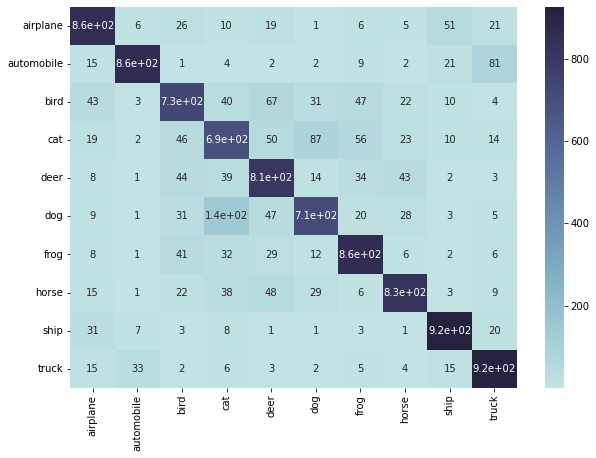

In [17]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

### 3. ResNet Model v3 - 6

In [21]:
def resnet_v3():
    input_layer = keras.Input(shape = (32, 32, 3), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P2 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R3)
    
    R4, A4 = residual_block(P2, P2, 128, (3, 3))
    R5, A5 = residual_block(R4, A4, 128, (3, 3))
    
    P3 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R5)
    
    R6, A6 = residual_block(P3, P3, 256, (3, 3))
    R7, A7 = residual_block(R6, A6, 256, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R7)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv3")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [22]:
resnet_v3 = resnet_v3()

In [23]:
history = resnet_v3.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20


2022-10-25 18:59:13.091536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.5019 - accuracy: 0.4422

2022-10-25 19:00:28.139450: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 82s 52ms/step - loss: 1.5019 - accuracy: 0.4422 - val_loss: 1.0971 - val_accuracy: 0.6078
Epoch 2/20
1563/1563 [==============================] - 81s 52ms/step - loss: 0.9240 - accuracy: 0.6734 - val_loss: 0.9137 - val_accuracy: 0.6807
Epoch 3/20
1563/1563 [==============================] - 87s 56ms/step - loss: 0.6858 - accuracy: 0.7622 - val_loss: 0.6754 - val_accuracy: 0.7729
Epoch 4/20
1563/1563 [==============================] - 88s 57ms/step - loss: 0.5525 - accuracy: 0.8080 - val_loss: 0.6679 - val_accuracy: 0.7809
Epoch 5/20
1563/1563 [==============================] - 88s 56ms/step - loss: 0.4594 - accuracy: 0.8405 - val_loss: 0.5964 - val_accuracy: 0.8037
Epoch 6/20
1563/1563 [==============================] - 88s 56ms/step - loss: 0.3835 - accuracy: 0.8670 - val_loss: 0.5823 - val_accuracy: 0.8105
Epoch 7/20
1563/1563 [==============================] - 88s 56ms/step - loss: 0.3168 - accuracy: 0.8899 - val_loss: 0.6369 - val_accura

In [24]:
predictions = resnet_v3.predict(X_test)

  1/313 [..............................] - ETA: 1:10

2022-10-25 19:27:44.023470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 6s 20ms/step


In [25]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

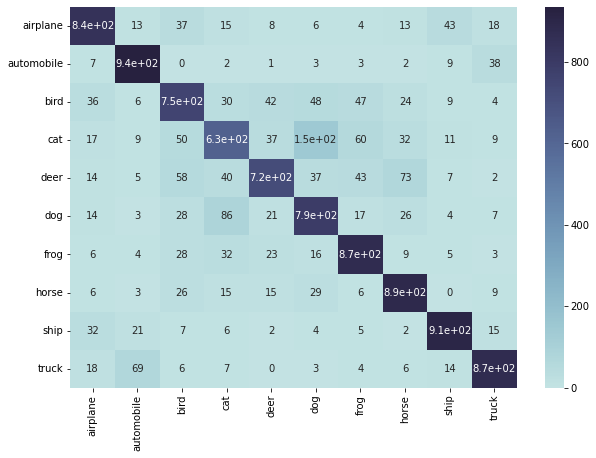

In [26]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()

### 4. ResNet Model v4 - 8

In [27]:
def resnet_v4():
    input_layer = keras.Input(shape = (32, 32, 3), name = "input_1")
    
    A1 = tkl.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), padding = "same", activation = "relu", kernel_initializer = "he_normal", bias_initializer = "he_normal")(input_layer)
    
    R2, A2 = residual_block(A1, A1, 64, (3, 3))
    R3, A3 = residual_block(R2, A2, 64, (3, 3))
    
    P2 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R3)
    
    R4, A4 = residual_block(P2, P2, 128, (3, 3))
    R5, A5 = residual_block(R4, A4, 128, (3, 3))
    
    P3 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R5)
    
    R6, A6 = residual_block(P3, P3, 256, (3, 3))
    R7, A7 = residual_block(R6, A6, 256, (3, 3))
    
    P4 = tkl.MaxPool2D(pool_size = (3, 3), strides = (2, 2), padding = "same")(R7)
    
    R8, A8 = residual_block(P4, P4, 512, (3, 3))
    R9, A9 = residual_block(R8, A8, 512, (3, 3))
    
    P5 = tkl.GlobalAveragePooling2D(name = "pool_5")(R9)
    
    output = tkl.Dense(10, activation = "softmax", name = "output", kernel_initializer = "he_normal", bias_initializer = "he_normal")(P5)
    
    model = keras.Model(input_layer, output, name = "ResNetv4")
    model.compile(
        loss = keras.losses.SparseCategoricalCrossentropy(),
        optimizer = keras.optimizers.Adam(),
        metrics = ["accuracy"]
    )
    return model

In [28]:
resnet_v4 = resnet_v4()

In [29]:
resnet_v4.summary()

Model: "ResNetv4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_40 (Conv2D)             (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_40[0][0]']              
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_41[0][0]']              
                                                                                           

In [30]:
history = resnet_v4.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 20)

Epoch 1/20


2022-10-25 19:27:52.821544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - ETA: 0s - loss: 1.6913 - accuracy: 0.3908

2022-10-25 19:29:32.232554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1563/1563 [==============================] - 107s 67ms/step - loss: 1.6913 - accuracy: 0.3908 - val_loss: 1.1898 - val_accuracy: 0.5737
Epoch 2/20
1563/1563 [==============================] - 103s 66ms/step - loss: 1.0470 - accuracy: 0.6278 - val_loss: 0.8917 - val_accuracy: 0.6924
Epoch 3/20
1563/1563 [==============================] - 103s 66ms/step - loss: 0.7919 - accuracy: 0.7224 - val_loss: 0.8039 - val_accuracy: 0.7279
Epoch 4/20
1563/1563 [==============================] - 104s 67ms/step - loss: 0.6569 - accuracy: 0.7718 - val_loss: 0.7260 - val_accuracy: 0.7545
Epoch 5/20
1563/1563 [==============================] - 103s 66ms/step - loss: 0.5605 - accuracy: 0.8047 - val_loss: 0.6734 - val_accuracy: 0.7754
Epoch 6/20
1563/1563 [==============================] - 106s 68ms/step - loss: 0.4850 - accuracy: 0.8301 - val_loss: 0.6623 - val_accuracy: 0.7814
Epoch 7/20
1563/1563 [==============================] - 103s 66ms/step - loss: 0.4309 - accuracy: 0.8506 - val_loss: 0.6456 - val

In [31]:
predictions = resnet_v4.predict(X_test)

  1/313 [..............................] - ETA: 1:14

2022-10-25 20:01:56.592134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 5s 16ms/step


In [32]:
confusion_matrix = tf.math.confusion_matrix(y_test, np.argmax(predictions, axis = 1), 10)

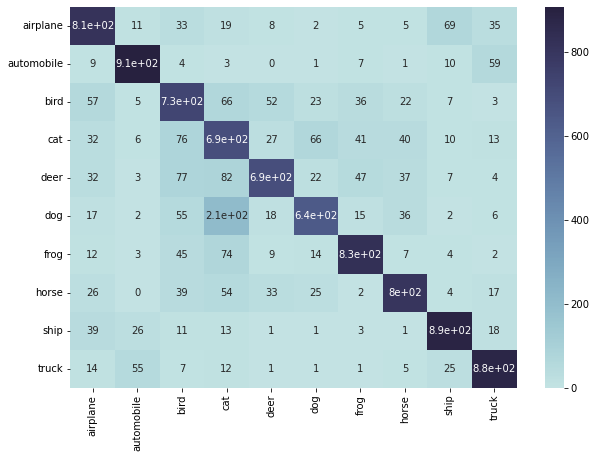

In [33]:
df_cm = pd.DataFrame(confusion_matrix, index = classes, columns = classes)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=sn.color_palette("ch:start=.2,rot=-.3", as_cmap=True))
plt.show()